# Preparing data

We will use **IMDb movie review dataset** for binary sentiment analysis (http://ai.stanford.edu/~amaas/data/sentiment/).

Since the data is represented in particular files for each review, we need to apply some helper functions to collect data properly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, WordPunctTokenizer

In [ ]:
def tokenize_text(text):
    return WordPunctTokenizer().tokenize(text)

def collect_data(filename):
    path = 'drive/My Drive/aclImdb'
    data = []
    with open(os.path.join(path, filename), 'r') as file:
        for paragraph in file.read().splitlines():
            data.append(tokenize_text(paragraph))
    return data

In [ ]:
X_train_pos = collect_data('X_train_pos')
X_train_neg = collect_data('X_train_neg')

X_test_pos = collect_data('X_test_pos')
X_test_neg = collect_data('X_test_neg')

In [ ]:
X_train = np.array(X_train_pos + X_train_neg)
X_test = np.array(X_test_pos + X_test_neg)

In [ ]:
Y_train = np.concatenate((np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))))
Y_test = np.concatenate((np.ones(len(X_test_pos)), np.zeros(len(X_test_neg))))

# Build word embeddings to represent texts


##Word2Vec embeddings

First we want to load pre-trained **word2vec** to represent words with vectors, so words that appear in similar contexts will have vectors with greater scalar product. Then we can try different ways to represent texts: as mean of vectors of incoming words and etc.

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [ ]:
corpus = api.load('text8')
word2vec = Word2Vec(corpus, size=100, window=5, min_count=5).wv

[==================================================] 100.0% 31.6/31.6MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


So, now we can look for words with most similar contexts to some word, for instance *'kubrick'*.

In [ ]:
word2vec.most_similar('kubrick')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lugosi', 0.8195202350616455),
 ('lynch', 0.8152298331260681),
 ('mitchell', 0.7943451404571533),
 ('welles', 0.7931139469146729),
 ('gibson', 0.7788679003715515),
 ('scorsese', 0.7748708724975586),
 ('spielberg', 0.7741739749908447),
 ('gilliam', 0.7725070118904114),
 ('burton', 0.7651768922805786),
 ('osbourne', 0.7646410465240479)]

Now we can start representing texts to learn an algorithm on the training data that predicts texts' labels! Let's try different ways to get text's embedding.

In [ ]:
def mean_text_embedding(text, embeddings, word_vectors):    
    return np.mean(np.array([word_vectors[word] for word in text if word in embeddings.vocab.keys()]), axis=0)

In [ ]:
class EmbeddingMaker():
    def __init__(self, embeddings, text_function):
        self.embeddings = embeddings
        self.text_function = text_function
        self.form_word_structures(self.embeddings)
    
    def form_word_structures(self, embeddings):
        self.words = sorted(self.embeddings.vocab.keys(),
                            key=lambda word: self.embeddings.vocab[word].count,
                            reverse=True)
        self.word_vectors = {word : self.embeddings.get_vector(word) for word in self.words}

    def get_text_embedding(self, text):
        return self.text_function(text, self.embeddings, self.word_vectors)

    def get_corpus_embeddings(self, corpus):
        return np.stack(([self.text_function(text, self.embeddings, self.word_vectors) for text in corpus]))

In [ ]:
word2vec_mean = EmbeddingMaker(word2vec, mean_text_embedding)

In [ ]:
word2vec_mean.get_text_embedding(X_train[0])

array([-4.67617400e-02,  2.63181478e-01,  3.90926711e-02, -4.17325109e-01,
        2.30888620e-01, -2.05782861e-01, -8.33507776e-01, -1.46179408e-01,
       -3.16390442e-03,  5.40673316e-01, -2.98262686e-01, -8.12956616e-02,
       -4.91674207e-02, -5.50487578e-01, -2.08392859e-01, -1.78316697e-01,
       -2.94999033e-01,  1.80090610e-02,  3.70815635e-01,  4.41562325e-01,
        1.34810889e+00, -2.67927766e-01,  1.16347946e-01,  6.89461172e-01,
        3.01863492e-01,  1.49546981e-01, -2.04884559e-01, -5.54269738e-02,
        3.75169963e-01,  8.61668229e-01, -8.40959996e-02,  1.20953977e-01,
        3.91044766e-01,  1.12622760e-01, -2.42081508e-02,  8.70090201e-02,
        1.67460561e-01,  2.02588797e-01,  8.13160907e-04,  2.03196287e-01,
       -5.72743356e-01,  2.07716540e-01, -3.54234219e-01,  8.05752873e-02,
       -5.74538857e-02, -1.46449372e-01,  3.21996003e-01, -1.60134640e-02,
        8.57537240e-02, -8.39313492e-03,  3.69858705e-02,  3.48290205e-01,
       -1.11973234e-01,  

In [ ]:
X_train_mean_word2vec = word2vec_mean.get_corpus_embeddings(X_train)

In [ ]:
print(X_train_mean_word2vec.shape)

(25000, 100)


In [ ]:
X_test_mean_word2vec = word2vec_mean.get_corpus_embeddings(X_test)

###Linear models performance

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [ ]:
class EstimatorChecker():
    def __init__(self, estimator, method_name, X_train, Y_train, X_test, Y_test):
        self.estimator = estimator
        self.method_name = method_name
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

    def fit_to_best_params(self, param_grid):
        self.searcher = RandomizedSearchCV(self.estimator, param_grid, n_iter=10, cv=3)
        self.searcher.fit(self.X_train, self.Y_train)

        self.estimator.set_params(**self.searcher.best_params_)
        print('{} best params: {}'.format(self.method_name, self.searcher.best_params_))
        print('Best cross_val score: {}'.format(self.searcher.best_score_))

    def fit(self):
        self.estimator = self.estimator.fit(self.X_train, self.Y_train)

    def predict(self):
        self.Y_pred = self.estimator.predict(self.X_test)
        return self.Y_pred

    def print_scores(self):
        print('Scores for {}:'.format(self.method_name))
        print('Accuracy: {}'.format(accuracy_score(self.Y_test, self.Y_pred)))
        print('Precision: {}'.format(precision_score(self.Y_test, self.Y_pred)))
        print('Recall: {}'.format(recall_score(self.Y_test, self.Y_pred)))

    def plot_roc_curve(self):
        fpr, tpr, _ = roc_curve(self.Y_test, 
                                self.estimator.predict_proba(self.X_test)[:, 1], 
                                pos_label=1)
        plt.figure(figsize=(15, 8))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.grid(c='g')
        plt.title('ROC-curve for {}'.format(self.method_name))
        print('Area under ROC-curve: {:1.4f}'.format(auc(fpr, tpr)))
        plt.plot(fpr, tpr)
        plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 'r')
        plt.show()

    def iterate_and_report(self):
        self.fit()
        self.predict()
        self.print_scores()
        self.plot_roc_curve()

In [ ]:
log_regr = EstimatorChecker(estimator=LogisticRegression(max_iter=300, random_state=1),
                            method_name='Logistic Regression',
                            X_train=X_train_mean_word2vec,
                            Y_train=Y_train,
                            X_test=X_test_mean_word2vec,
                            Y_test=Y_test)

In [ ]:
log_regr_param_grid = {'fit_intercept' : [True, False], 
                       'C' : np.logspace(-4, 3, num=8)}
log_regr.fit_to_best_params(log_regr_param_grid)

Logistic Regression best params: {'fit_intercept': True, 'C': 1.0}
Best cross_val score: 0.7565602024128961


Scores for Logistic Regression:
Accuracy: 0.755
Precision: 0.7603528546924774
Recall: 0.74472
Area under ROC-curve: 0.8316


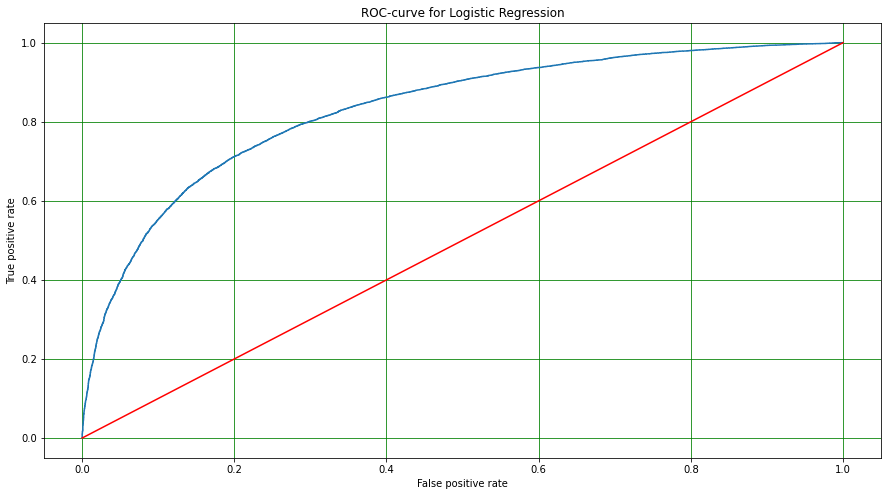

In [ ]:
log_regr.iterate_and_report()

In [ ]:
word_weights = np.array([np.dot(log_regr.coef_, word_vectors[word]) for word in words])

In [ ]:
top_weights = np.argsort(word_weights, axis=0)[:20].ravel()
print([words[i] for i in top_weights])

['either', 'whether', 'external', 'prevent', 'remove', 'y', 'killed', 'any', 'avoid', 'k', 'kill', 'africa', 'o', 'killing', 'otherwise', 'removed', 'forced', 'prison', 'soviet', 'named']


In [ ]:
rf = EstimatorChecker(estimator=RandomForestClassifier(random_state=1),
                            method_name='Random Forest',
                            X_train=X_train_mean_word2vec,
                            Y_train=Y_train,
                            X_test=X_test_mean_word2vec,
                            Y_test=Y_test)

In [ ]:
rf_param_grid = {'n_estimators' : np.linspace(100, 300, 101).astype(int), 
                 'max_depth' : np.linspace(5, 20, 6).astype(int)}
rf.fit_to_best_params(rf_param_grid)

Random Forest best params: {'n_estimators': 262, 'max_depth': 20}
Best cross_val score: 0.7163201382866929


Scores for Random Forest:
Accuracy: 0.7134
Precision: 0.7115216874157482
Recall: 0.71784
Area under ROC-curve: 0.7848


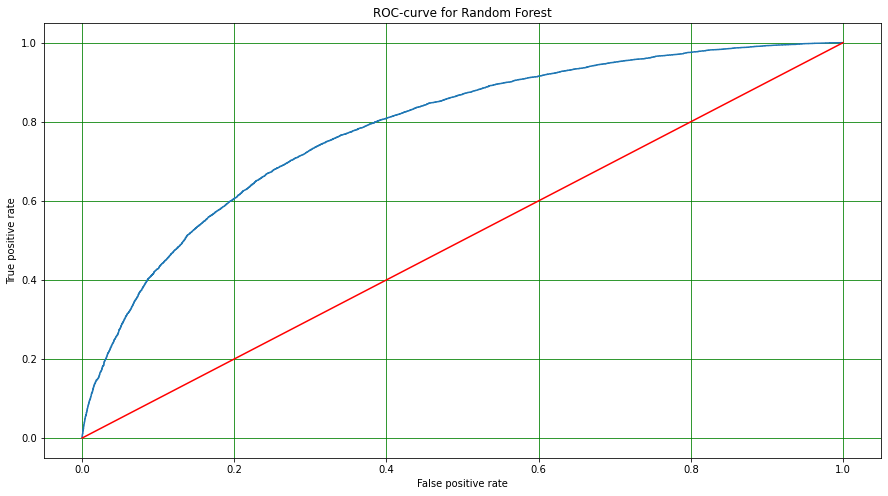

In [ ]:
rf.iterate_and_report()

In [ ]:
def NegativeCosineSimilarity(x, y):
    if x.shape != y.shape:
        raise ValueError("x and y need to have the same length")
    return -np.dot(x, y) / (np.sqrt((x ** 2).sum() * (y ** 2).sum()) + 10 ** -9)

In [ ]:
def NegativeScalarProduct(x, y):
    if x.shape != y.shape:
        raise ValueError("x and y need to have the same length")
    return -np.dot(x, y)

In [ ]:
kNN = EstimatorChecker(KNeighborsClassifier(),
                       method_name='kNN',
                       X_train=X_train_mean_word2vec,
                       Y_train=Y_train,
                       X_test=X_test_mean_word2vec,
                       Y_test=Y_test)

In [ ]:
kNN_param_grid = {'metric' : [NegativeCosineSimilarity, NegativeScalarProduct],
                  'n_neighbors' : np.arange(1, 11)}
kNN.fit_to_best_params(kNN_param_grid)

kNN best params: {'n_neighbors': 1, 'metric': <function NegativeCosineSimilarity at 0x7fd9b0963488>}
Best cross_val score: 0.5233584961349018


Scores for kNN:
Accuracy: 0.5268
Precision: 0.5478161575792179
Recall: 0.30704
Area under ROC-curve: 0.5268


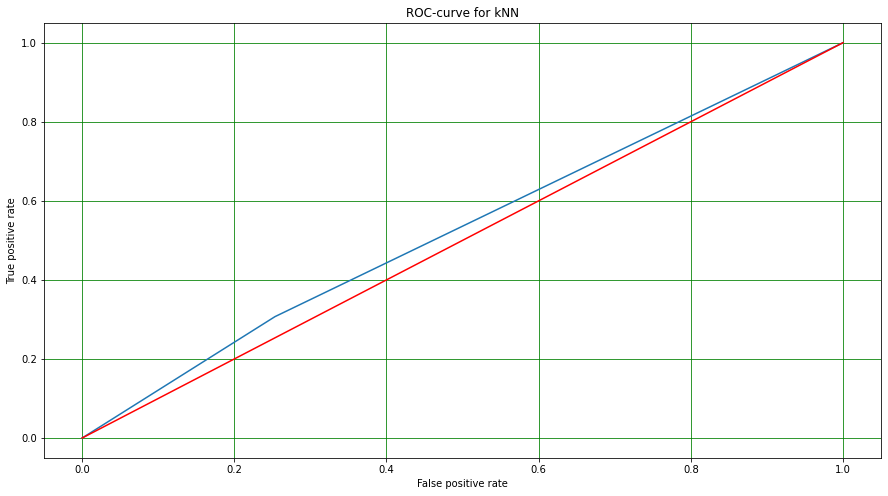

In [ ]:
kNN.iterate_and_report()

##Glove embeddings

Now let's try another way to create word embeddings and check its performance for our problem.

In [ ]:
glove = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
glove.most_similar('kubrick')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('spielberg', 0.7951244711875916),
 ('welles', 0.7051688432693481),
 ('soderbergh', 0.7047620415687561),
 ('selznick', 0.6845448613166809),
 ('altman', 0.681014358997345),
 ('bergman', 0.6685311794281006),
 ('capote', 0.6658517122268677),
 ('screenplay', 0.661378800868988),
 ('hitchcock', 0.6600087881088257),
 ('zemeckis', 0.6493422389030457)]

In [ ]:
glove_mean = EmbeddingMaker(glove, mean_text_embedding)

In [ ]:
X_train_mean_glove = glove_mean.get_corpus_embeddings(X_train)

X_test_mean_glove = glove_mean.get_corpus_embeddings(X_test)

###Linear models performance

In [ ]:
log_regr = EstimatorChecker(estimator=LogisticRegression(max_iter=300, random_state=1),
                            method_name='Logistic Regression',
                            X_train=X_train_mean_glove,
                            Y_train=Y_train,
                            X_test=X_test_mean_glove,
                            Y_test=Y_test)

In [ ]:
log_regr_param_grid = {'fit_intercept' : [True, False], 
                       'C' : np.logspace(-4, 3, num=8)}
log_regr.fit_to_best_params(log_regr_param_grid)

Logistic Regression best params: {'fit_intercept': True, 'C': 1000.0}
Best cross_val score: 0.7560402344099524


Scores for Logistic Regression:
Accuracy: 0.75624
Precision: 0.7615975171512578
Recall: 0.746
Area under ROC-curve: 0.8318


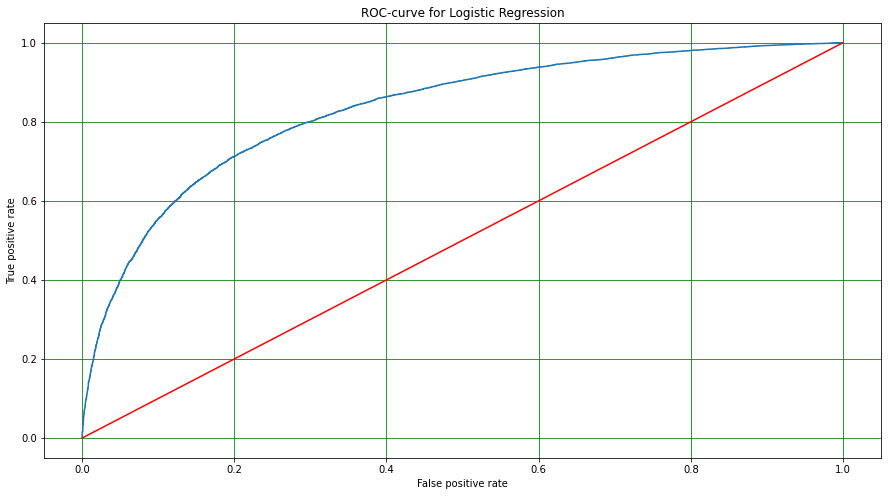

In [ ]:
log_regr.iterate_and_report()

In [ ]:
rf = EstimatorChecker(estimator=RandomForestClassifier(random_state=1),
                            method_name='Random Forest',
                            X_train=X_train_mean_glove,
                            Y_train=Y_train,
                            X_test=X_test_mean_glove,
                            Y_test=Y_test)

In [ ]:
rf_param_grid = {'n_estimators' : np.linspace(100, 300, 101).astype(int), 
                 'max_depth' : np.linspace(5, 20, 6).astype(int)}
rf.fit_to_best_params(rf_param_grid)

Random Forest best params: {'n_estimators': 278, 'max_depth': 20}
Best cross_val score: 0.754920151209696


Scores for Random Forest:
Accuracy: 0.7462
Precision: 0.7441491471638239
Recall: 0.7504
Area under ROC-curve: 0.8220


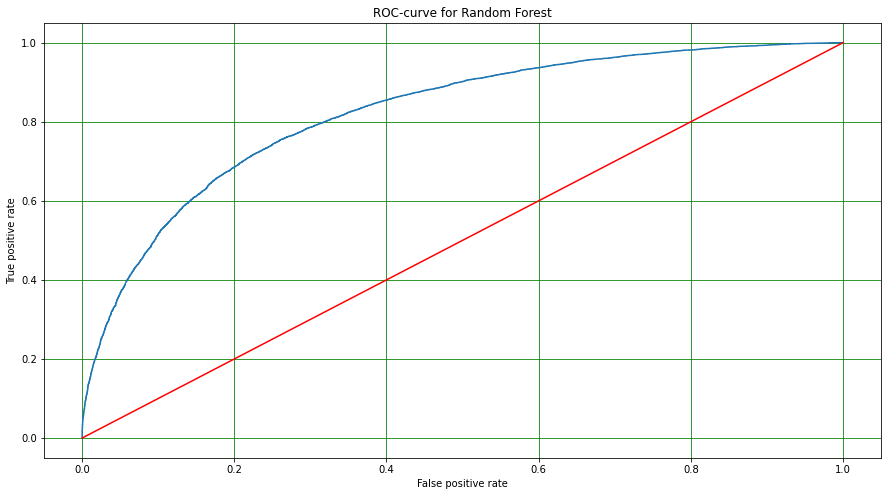

In [ ]:
rf.iterate_and_report()